In [1]:
import sys
import os
import random
import json
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict

import torch
from torchvision import transforms

from sklearn.metrics import roc_auc_score, precision_recall_fscore_support

torch.set_printoptions(precision=2,sci_mode=False)

from openloris.OpenLorisDataset import OpenLorisDataset
from openloris import full_streaming_experiment
from models.CLP import ContinuallyLearningPrototypes
from models.StreamingLDA import StreamingLDA
from utils import get_backbone
from openloris.open_loris_utils import get_stream_data_loader, get_class_change_boundaries, \
update_and_save_accuracies_ood, update_and_save_accuracies, update_and_save_accuracies_semi_supervised,\
get_class_change_boundaries, get_ood_loaders, save_model_size, save_accuracies

In [2]:
batch_size = 64
dataset_name = "openloris"
images_dir = "/home/ehajizad/datasets/OpenLORIS"
save_dir_results = "/home/ehajizad/dev/Embedded-CL/results/"
arch='efficientnet_b0'
label_level = 'class'
training = True
seed = 10
step_size = 32
num_classes = 40
test_order = None
perform_ood = True
ood_num_samples = 10000
ood_type = 'baseline'
device = 'cuda'
backbone, feature_size = get_backbone(arch, 'avg')
random.seed(seed)

/home/ehajizad/ss_learning/ssl_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ehajizad/ss_learning/ssl_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
expt_name = "clp_semi_supervised_th_070"

accuracies = {'base_acc_init': [], 'base_acc_final': [], 'novel_acc': [], 'base_model_size': [], 'final_model_size': []}

save_dir = save_dir_results + expt_name
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

all_classes = list(range(num_classes))

random.shuffle(all_classes)

base_classes = all_classes[:20]
new_classes = all_classes[20:]


In [2]:
n_shots_per_class = np.array([105,141,180,108,144,72,33,72,105,108,108,36,108,108,180,105,108,
                              108,324,108,72,180,36,72,144,108,108,177,108,108,108,108,36,36,144,144,72,108,36,72])

In [3]:
np.sum(n_shots_per_class)

4338

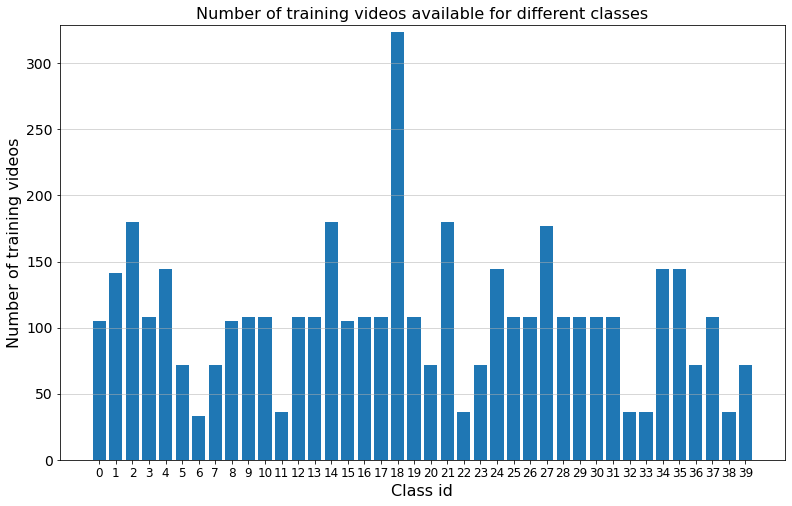

In [9]:
n_shots_per_class = np.array([105,141,180,108,144,72,33,72,105,108,108,36,108,108,180,105,108,
                              108,324,108,72,180,36,72,144,108,108,177,108,108,108,108,36,36,144,144,72,108,36,72])

plt.figure(figsize=(13,8))
X_axis = np.arange(len(n_shots_per_class))
plt.bar(X_axis, n_shots_per_class)

plt.ylim([0,max(n_shots_per_class)+5])
plt.xticks(X_axis, fontsize=12)
plt.yticks(fontsize=14)
plt.grid(linewidth=0.5, axis='y')

plt.title("Number of training videos available for different classes", size=16)
plt.xlabel("Class id", size=16)
plt.ylabel("Number of training videos", size=16)
plt.show()

In [10]:
exp_id = 1

tr_closed = get_stream_data_loader(images_dir, True, ordering='instance', batch_size=batch_size,
                                   shuffle=False,augment=True, seed=seed, label_level='class',
                                   dataset=dataset_name, seen_classes=base_classes)

classifier = ContinuallyLearningPrototypes(feature_size,
                                           n_protos=3000,
                                           num_classes=num_classes, 
                                           backbone=backbone,
                                           alpha_init=1,
                                           sim_th_init=0.70,
                                           n_wta=5,
                                           k_hit=1,
                                           k_miss=0.5,
                                           adaptive_th=False)
    
print('---------------------------------------------------------------------------')
print('Beginning base streaming training of base classes...')
print("Number of shots: full")
i = 0
test_classes = base_classes
for batch_ix, (batch_x, batch_y) in enumerate(tr_closed):

    batch_x_feat = classifier.backbone(batch_x.to(device)).detach()

    for x, y in zip(batch_x_feat, batch_y):

        # fit model
        classifier.fit(x, y.view(1, ), torch.tensor(i).long())
        i += 1


print('\nMaking test loader from all test data for learned classes: ')
test_loader = get_stream_data_loader(images_dir, False, ordering=test_order, batch_size=batch_size,
                                     seen_classes=test_classes, label_level=label_level, dataset=dataset_name)
probas, y_test_init = classifier.evaluate_(test_loader)
update_and_save_accuracies_semi_supervised(probas, y_test_init, save_dir, exp_id, accuracies, 0)

base_model_size = classifier.next_alloc_id_

print("Base model size: ", base_model_size)
classifier.save_model(save_dir, "base_model_" + str(exp_id))

---------------------------------------------------------------------------
Beginning base streaming training of base classes...
Number of shots: full

Making test loader from all test data for learned classes: 

Testing on 31104 images.

Index: 1 -- top1=99.18% -- top5=100.00%
Base model size:  1692


In [11]:
    
k_shot_list = [1,5,10,25,-1]

for k in k_shot_list:
    
    if k == -1:
        tr_open = get_stream_data_loader(images_dir, True, ordering='instance',
                                     batch_size=batch_size,shuffle=False, augment=True, 
                                     seed=seed, label_level='class',dataset=dataset_name,
                                     seen_classes=new_classes)
    else:
        tr_open = get_stream_data_loader(images_dir, True, ordering='instance_few_shot', k_shot=k,
                                     batch_size=batch_size,shuffle=False, augment=True, 
                                     seed=seed, label_level='class',dataset=dataset_name,
                                     seen_classes=new_classes)
    
    classifier = ContinuallyLearningPrototypes(feature_size,
                                               n_protos=3000,
                                               num_classes=num_classes, 
                                               backbone=backbone,
                                               alpha_init=1,
                                               sim_th_init=0.70,
                                               n_wta=5,
                                               k_hit=1,
                                               k_miss=0.5,
                                               adaptive_th=False,
                                               supervised=False)
    
    classifier.load_model(os.path.join(save_dir, "base_model_" + str(exp_id) + ".pth"))
    
    print('---------------------------------------------------------------------------')
    print('Beginning base streaming training of base classes...')
    print("Number of shots: ", k)
   
    # ----------------------------------------------------------------------------#
    # Unsupevised learning
    # classifier.supervised = False
    print('Beginning streaming training of new classes...')
    i = 0
    for batch_ix, (batch_x, batch_y) in enumerate(tr_open):

        batch_x_feat = classifier.backbone(batch_x.to(device)).detach()

        for x, y in zip(batch_x_feat, batch_y):

            # fit model
            classifier.fit(x, y.view(1, ), torch.tensor(i).long())
            i += 1
    
    final_model_size = classifier.next_alloc_id_
    
    print('\nTesting accuracy on base classes')
    test_loader = get_stream_data_loader(images_dir, False, ordering=test_order, batch_size=batch_size,
                                         seen_classes=base_classes, label_level=label_level, dataset=dataset_name)
    probas, y_test_init = classifier.evaluate_(test_loader)
    update_and_save_accuracies_semi_supervised(probas, y_test_init, save_dir, exp_id, accuracies, 1)
    

    print('\nTesting accuracy on new classes')
    test_loader = get_stream_data_loader(images_dir, False, ordering=test_order, batch_size=batch_size,
                                         seen_classes=new_classes, label_level=label_level, dataset=dataset_name)
    probas, y_test_init = classifier.evaluate_(test_loader)
    update_and_save_accuracies_semi_supervised(probas, y_test_init, save_dir, exp_id, accuracies, 2)
    
    save_model_size(base_model_size, final_model_size, save_dir, exp_id, accuracies)


loading ckpt from: /home/ehajizad/dev/Embedded-CL/results/clp_semi_supervised_th_070/base_model_1.pth
---------------------------------------------------------------------------
Beginning base streaming training of base classes...
Number of shots:  1
Beginning streaming training of new classes...

Testing accuracy on base classes

Testing on 31104 images.

Index: 1 -- top1=99.15% -- top5=100.00%

Testing accuracy on new classes

Testing on 22191 images.

Index: 1 -- top1=30.68% -- top5=61.61%

Base model size= 1692 -- Final model size= 1746

loading ckpt from: /home/ehajizad/dev/Embedded-CL/results/clp_semi_supervised_th_070/base_model_1.pth
---------------------------------------------------------------------------
Beginning base streaming training of base classes...
Number of shots:  5
Beginning streaming training of new classes...

Testing accuracy on base classes

Testing on 31104 images.

Index: 1 -- top1=99.15% -- top5=100.00%

Testing accuracy on new classes

Testing on 22191 i

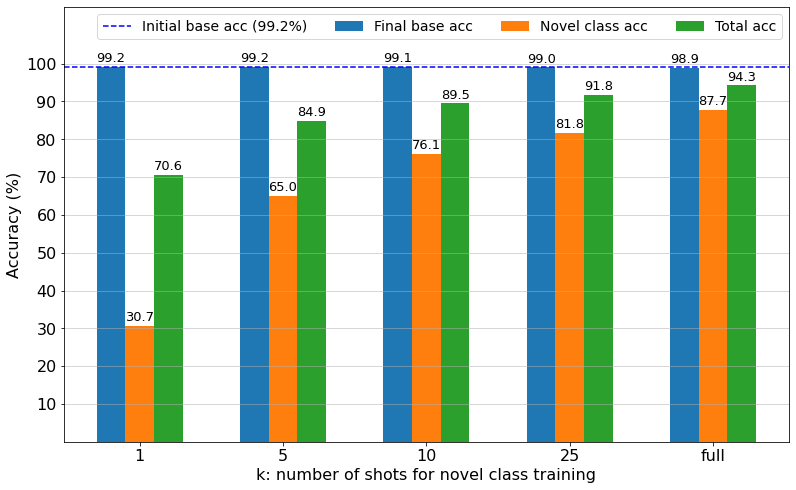

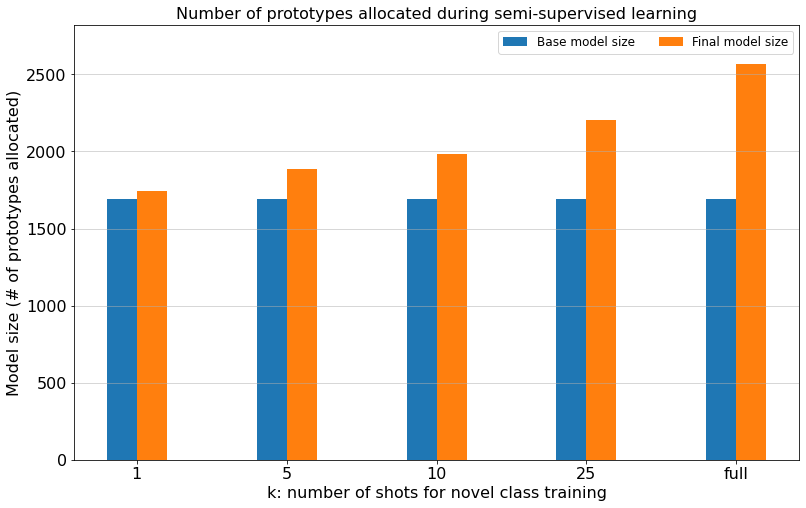

In [4]:
save_dir = save_dir_results + expt_name
results_dict = defaultdict(dict)
exp_id = 1
k_shot_list = [1,5,10,25,-1]

results_file = os.path.join(save_dir, "accuracies_index_" + str(exp_id)+".json")
with open(results_file, 'r') as f:
    d = json.load(f)
    keysList = list(d.keys()) 
    for key in keysList:
        results_dict[key] = d[key]

fig, ax = plt.subplots(figsize=(13,8))

X_axis = np.arange(len(k_shot_list))
plt.axhline(y = results_dict['base_acc_init'], color = 'b', linestyle = '--', label='Initial base acc (99.2%)')
bar1=plt.bar(X_axis-0.2, results_dict['base_acc_final'], 0.2, label='Final base acc')
bar2=plt.bar(X_axis, results_dict['novel_acc'], 0.2, label='Novel class acc')
bar3=plt.bar(X_axis+0.2, results_dict['total_acc'], 0.2, label='Total acc')

ax.bar_label(bar1, padding=2, fmt='%.1f', fontsize=13)
ax.bar_label(bar2, padding=2, fmt='%.1f', fontsize=13)
ax.bar_label(bar3, padding=2, fmt='%.1f', fontsize=13)

x_tick_labels = k_shot_list[:-1]
x_tick_labels.append("full")
plt.ylim([0,115])
plt.xticks(X_axis, x_tick_labels, fontsize=16)
plt.yticks(np.arange(10,109,10), fontsize=16)
plt.grid(linewidth=0.5, axis='y')

# plt.title("Semi-supervised k-shot OCL with 20 base and 20 novel classes", size=16)
plt.xlabel("k: number of shots for novel class training", size=16)
plt.ylabel("Accuracy (%)", size=16)
plt.legend(ncol=4, loc="upper right", fontsize=14)
plt.show()

save_name = 'semi_supervised_final_res'
if save_dir is not None:
    fig.savefig(os.path.join(save_dir, save_name + '.svg'), bbox_inches="tight", format='svg', dpi=600)

#-------------------- Model Size --------------------------------------------------
plt.figure(figsize=(13,8))
X_axis = np.arange(len(k_shot_list))
plt.bar(X_axis-0.1, results_dict['base_model_size'], 0.2, label='Base model size')
plt.bar(X_axis+0.1, results_dict['final_model_size'], 0.2, label='Final model size')

plt.ylim([0,1.1*max(results_dict['final_model_size'])])
plt.xticks(X_axis, x_tick_labels, fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linewidth=0.5, axis='y')

plt.title("Number of prototypes allocated during semi-supervised learning", size=16)
plt.xlabel("k: number of shots for novel class training", size=16)
plt.ylabel("Model size (# of prototypes allocated)", size=16)
plt.legend(ncol=3, loc="upper right", fontsize=12)
plt.show()


    

In [55]:
# results_file = os.path.join(save_dir, "accuracies_index_0.json")
# with open(results_file, 'r') as f:
#     d = json.load(f)
    
# save_accuracies(d, 0, save_dir)

In [13]:
nb = 31104
nn = 22191
wb = nb/(nb + nn)
wn = nn/(nb + nn)

total_accs = wb*np.array(results_dict['base_acc_final']) + wn*np.array(results_dict['novel_acc'])
total_accs = total_accs.tolist()

accuracies["total_acc"] = total_accs

save_accuracies(accuracies, 1,  save_dir)